In [1]:
import time, csv
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


# Preprocessing data

In [2]:
# Trace data
# all_x = scipy.io.loadmat('./dataset/timeseries/Trace_data.mat')['data']
# all_y = scipy.io.loadmat('./dataset/timeseries/Trace_label.mat')['label'][0]

In [ ]:
# gun point
all_x, all_y = [], []
with open('./dataset/timeseries/Gun_Point/Gun_Point_TRAIN') as csvfile:
  reader = csv.reader(csvfile)
  for row in reader:
    all_y.append(row[0])
    all_x.append(row[1:])

all_x = np.array(all_x, np.float32)
all_y = np.array(all_y, np.float32)

In [ ]:
print(all_x)
print(all_y)

In [3]:
x, y = [], []

class_1 = 1
class_2 = 4

for i in range(len(all_x)):
  if all_y[i] == class_1 or all_y[i] == class_2:
    x.append(all_x[i][:200])
    y.append(all_y[i])

x = np.array(x)
y = np.array(y)
y = np.where(y == class_2, -1, 1)
y = y.reshape(-1, 1)

print(x)
print(y)

[[ 0.56421375  0.54511617  0.54204671 ...  0.23900864  0.2035571
   0.20117864]
 [ 0.6376156   0.58507817  0.62313348 ...  0.32094571  0.2853001
   0.25950175]
 [-1.4043092  -1.4425306  -1.415186   ...  0.74640323  0.6894699
   0.76927325]
 ...
 [ 0.64550395  0.57923708  0.64327477 ...  0.51632464  0.52290732
   0.55828421]
 [ 0.57311057  0.66785286  0.6204376  ...  0.5212762   0.51004323
   0.5036782 ]
 [-1.4311198  -1.4549623  -1.4688949  ...  0.74562151  0.73998126
   0.76169572]]
[[ 1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]]


In [4]:
# Split test / train
train_cnt = 33

np.random.seed(10)
train_index = np.random.choice(len(x), size=train_cnt, replace=False)
print(train_index)
test_index = [i for i in np.arange(0, len(x)) if i not in train_index]

train_x = x[train_index]
train_y = y[train_index]

test_x = x[test_index]
test_y = y[test_index]

print(np.shape(train_x))
print(np.shape(test_x))

[31 21 27  7 32 24  2 17 18 20 12  6 33  3 26  5 13 14 37 30  1 23 35 11
 40 38 16 19  4 22 34 10 39]
(33, 200)
(10, 200)


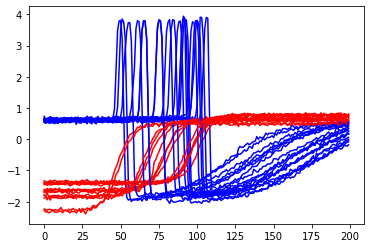

In [5]:
for i in range(len(train_x)):
  plt.plot(train_x[i].ravel(), 'b' if train_y[i] == 1 else 'r')
plt.show()

1
1
-1
-1
-1
1
1
-1
1
-1


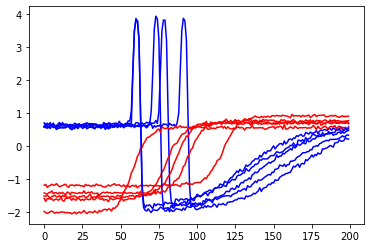

In [6]:
for i in range(len(test_x)):
  print(test_y[i][0])
  plt.plot(test_x[i].ravel(), 'b' if test_y[i] == 1 else 'r')
plt.show()

In [7]:
batch = int(np.shape(train_x)[0] / 2)
batch = int(np.shape(train_x)[0])
iter = 5
lr = 0.01
gamma = 1.8

In [8]:
X = tf.placeholder(shape=[None, None], dtype=tf.float32)
pred_X = tf.placeholder(shape=[None, None], dtype=tf.float32)
test_X = tf.placeholder(shape=[None, None], dtype=tf.float32)

Y = tf.placeholder(shape=[None, 1], dtype=tf.float32)
test_Y = tf.placeholder(shape=[None, 1], dtype=tf.float32)

B = tf.Variable(tf.random_uniform(shape=[1, batch]))

In [9]:
def _dtw(X1, X2):
  dtw_array = []
  for i in range(len(X1)):
    tmp_i = []
    for j in range(len(X2)):
      distance = fastdtw(X1[i], X2[j], dist=euclidean)
      tmp_i.append(distance[0])

    dtw_array.append(tmp_i)

  return dtw_array

In [10]:
G = tf.constant(gamma)
dtw_distances = tf.py_function(func=_dtw, inp=[X, X], Tout=[tf.float32 for i in range(batch)])

kernel = tf.exp(-tf.multiply(G, dtw_distances))

In [11]:
first_term = tf.reduce_sum(B)

second_term = tf.reduce_sum(
  tf.multiply(
    kernel,
    tf.multiply(
      tf.matmul(tf.transpose(B), B),
      tf.matmul(Y, tf.transpose(Y))
    )
  )
)

loss = tf.negative(tf.subtract(first_term, second_term))

In [12]:
pred_dtw_distances = tf.py_function(func=_dtw, inp=[X, pred_X], Tout=[tf.float32 for i in range(batch)])
pred_kernel = tf.exp(-tf.multiply(G, pred_dtw_distances))

prediction_output = tf.matmul(tf.multiply(tf.transpose(Y), B), pred_kernel)
prediction = tf.sign(prediction_output - tf.reduce_mean(prediction_output))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(Y)), tf.float32))

In [13]:
test_dtw_distances = tf.py_function(func=_dtw, inp=[X, test_X], Tout=[tf.float32 for i in range(batch)])
test_kernel = tf.exp(-tf.multiply(G, test_dtw_distances))

test_prediction_output = tf.matmul(tf.multiply(tf.transpose(Y), B), test_kernel)
test_prediction = tf.sign(test_prediction_output - tf.reduce_mean(test_prediction_output))

test_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(test_prediction), tf.squeeze(test_Y)), tf.float32))

In [14]:
optimizer = tf.train.GradientDescentOptimizer(lr)
train = optimizer.minimize(loss)
init = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [36]:
start = time.time()

loss_vec = []
batch_accuracy = []

rand_index = []
for i in range(iter):
  print('Step #' + str(i+1))
  local_start = time.time()

  rand_index = np.random.choice(len(train_x), size=batch, replace=False)
  rand_x = train_x[rand_index]
  rand_y = train_y[rand_index]

  sess.run(train, feed_dict={X: rand_x, Y: rand_y})
  temp_loss = sess.run(loss, feed_dict={X: rand_x, Y: rand_y})
  loss_vec.append(temp_loss)

  acc_temp = sess.run(accuracy, feed_dict={X: rand_x, Y: rand_y, pred_X: rand_x})
  batch_accuracy.append(acc_temp)

  print("accuracy :", acc_temp)
  print("loss:", str(temp_loss))
  print("time :", time.time() - local_start)

print("Total time :", time.time() - start)

Step #1
[ 9 28 26 17 31  4  6 24  7 21  3 25 27 30 11  1 12 32 19 18 13  5 22 23
  0 14  8  2 10 16 20 15 29]
Step #2
[18 31 29  3 24  2 22  0 19  5 17 30 15  1 26  7 11 23  8 25 20 27 28 16
 12  9 10  6 32 21 13 14  4]
Step #3
[22  7 24 27 15 28 14 26  1 13 21  2 25 31 11  0 32  3  9  4 10 16  8  6
 12 23 30 20 19 18  5 29 17]
Step #4
[ 4 27  9 32 16 29 28 20 26 19 30 12 25 11  1 14  2 18 23  7 15  5  6 24
 31 22  3 13 17  8 10  0 21]
Step #5
[22  3  8 17 14 21 29 30  4 28 13 20  1 23 18  9 25  7  6 27 11 19 24 32
  5  0 15 10 12 26 31  2 16]
Total time : 0.002476215362548828


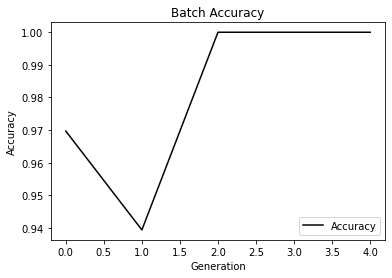

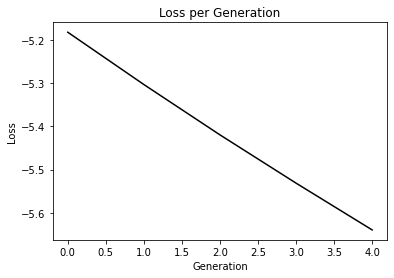

In [16]:
plt.plot(batch_accuracy, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

In [17]:
test_preds = sess.run(test_prediction,
                      feed_dict={
                          X: train_x[rand_index],
                          Y: train_y[rand_index],
                          test_X: test_x
                      })

In [18]:
test_acc = sess.run(test_accuracy,
                      feed_dict={
                          X: train_x[rand_index],
                          Y: train_y[rand_index],
                          test_X: test_x,
                          test_Y: test_y
                      })

In [19]:
print(test_acc)

1.0


In [20]:
test_preds = np.squeeze(test_preds)
_test_y = np.squeeze(test_y)

colors = []
cnt = 0
for i in range(len(test_preds)):
  if test_preds[i] == _test_y[i]:
    cnt += 1
    colors.append('b')

  else:
    colors.append('r')

print(cnt)
print(cnt / len(test_preds))


10
1.0


## Influence function

### Gradient for target data

In [26]:
inf_X = tf.placeholder(shape=[None, None], dtype=tf.float32)
inf_dtw_distances = tf.py_function(func=_dtw, inp=[x, inf_X], Tout=[tf.float32 for i in range(batch)])
inf_kernel = tf.exp(-tf.multiply(G, inf_dtw_distances))

In [27]:
inf_first_term = tf.reduce_sum(B)
inf_second_term = tf.reduce_sum(
  tf.multiply(
    inf_kernel,
    tf.multiply(
      tf.matmul(tf.transpose(B), B),
      tf.matmul(Y, tf.transpose(Y))
    )
  )
)

inf_loss = tf.negative(tf.subtract(inf_first_term, inf_second_term))
inf_grad_op = tf.gradients(inf_loss, [B])
inf_hess_op = tf.hessians(inf_loss, [B])

In [28]:
test_index = 1

In [31]:
inf_target_grad = sess.run(inf_grad_op, feed_dict={
  X: train_x[rand_index],
  Y: train_y[rand_index],
  inf_X: [test_x[test_index]]
})

inf_hess = sess.run(inf_hess_op, feed_dict={
  X: train_x[rand_index],
  Y: train_y[rand_index],
  inf_X: train_x
})

inf_hess = np.squeeze(inf_hess)
inf_inv_hess = np.linalg.inv(inf_hess)

In [32]:
infs = []

for i in range(len(rand_index)):
  inf_train_grad = sess.run(inf_grad_op, feed_dict={
    X: train_x[rand_index],
    Y: train_y[rand_index],
    inf_X: [train_x[rand_index[i]]]
  })

  inf_train_grad = np.squeeze(inf_train_grad)
  z_hess_grad = np.matmul(-inf_inv_hess, inf_train_grad)

  inf_val = np.matmul(inf_train_grad, z_hess_grad)
  infs.append((rand_index[i], inf_val))

In [33]:
infs = sorted(infs, key=lambda x: x[1])

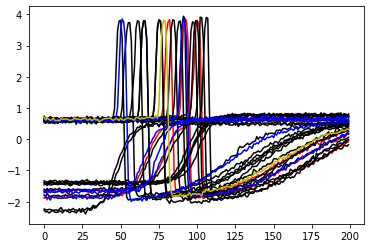

In [35]:
for i in range(len(infs)):
  color = 'k'
  if i < 5:
    color = 'r'
  elif i > 27:
    color = 'b'

  plt.plot(train_x[infs[i][0]], color)

plt.plot(test_x[test_index], 'y')
plt.show()
